In [265]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,-60.350,-46.133,NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,19.87,133.88
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,12.60,56.80


In [266]:
# Function to convert 'hh:mm' to fraction of the day
def time_to_fraction(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return (hours * 60 + minutes) / 1440

# Apply the function to the 'time' column
df['time_fraction'] = df['Meldingsklokkeslett'].apply(time_to_fraction)

# Convert time_fraction to radians for sine and cosine transformation
df['time_angle'] = df['time_fraction'] * 2 * np.pi

# Create sine and cosine features
df['time_sin'] = np.sin(df['time_angle'])
df['time_cos'] = np.cos(df['time_angle'])
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,time_fraction,time_angle,time_sin,time_cos
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,-60.350,-46.133,NaN,...,5.0,28 m og over,9432.0,NaN,19.87,133.88,0.0,0.0,0.0,1.0
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,5.0,28 m og over,1476.0,NaN,12.60,56.80,0.0,0.0,0.0,1.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,5.0,28 m og over,1476.0,NaN,12.60,56.80,0.0,0.0,0.0,1.0
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,5.0,28 m og over,1476.0,NaN,12.60,56.80,0.0,0.0,0.0,1.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,5.0,28 m og over,1476.0,NaN,12.60,56.80,0.0,0.0,0.0,1.0


In [267]:

#Sile ut informasjon:
df = df[(df['Art - FDIR (kode)'] == 1022) | (df['Art - FDIR (kode)'] == 1027)] # Fiske som fanger hyse eller torsk. "751 - lodde, 1022 Torsk"
area = [7, 8, 28, 30, 40]
df = df[(df['Redskap FDIR (kode)'] == 51)] #& (df['Hovedområde start (kode)'].isin(area))] # Fiske med bunntrål - 51, snurrevad - 11
df['Bruttotonnasje Kombinert'] = df['Bruttotonnasje 1969'].fillna(df['Bruttotonnasje annen']) # Slår sammen kolonnene.
df = df[df['Trekkavstand'] <= 10000]
# Dropper unødvendig informasjon. Tabellen inneholder masse duplikater. som egen kolonne for navn og for kode
# Forskjellige klassifiseringsmåter. Holder på FDIR sine.
df.drop(columns = ['Meldingsdato', 
                   'Meldingsklokkeslett', 
                   'Startdato',  
                   'Hovedområde start', 
                   'Lokasjon start (kode)', 
                   'Stoppdato', 
                   'Stoppklokkeslett', 
                   'Fangstår', 
                   'Hovedområde stopp (kode)', 
                   'Hovedområde stopp', 
                   'Lokasjon stopp (kode)', 
                   'Redskap FAO (kode)', 
                   'Redskap FAO', 
                   'Redskap FDIR', 
                   'Hovedart FAO (kode)', 
                   'Hovedart FAO', 
                   'Art FAO (kode)',
                   'Art FAO',
                   'Art - gruppe', 
                   'Lengdegruppe', 
                   'Bredde', 
                   'Fartøylengde',
                   'Bruttotonnasje 1969',
                   'Bruttotonnasje annen'
    ], inplace=True)

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
df['Bruttotonnasje Gruppert'] = pd.cut(df['Bruttotonnasje Kombinert'], bins=bins, labels=labels)
# Teller grupperingene
df['Bruttotonnasje Gruppert'].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16057 entries, 1 to 305405
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Melding ID                16057 non-null  int64   
 1   Meldingstidspunkt         16057 non-null  object  
 2   Starttidspunkt            16057 non-null  object  
 3   Startklokkeslett          16057 non-null  object  
 4   Startposisjon bredde      16057 non-null  float64 
 5   Startposisjon lengde      16057 non-null  float64 
 6   Hovedområde start (kode)  16057 non-null  float64 
 7   Havdybde start            16057 non-null  int64   
 8   Stopptidspunkt            16057 non-null  object  
 9   Varighet                  16057 non-null  int64   
 10  Stopposisjon bredde       16057 non-null  float64 
 11  Stopposisjon lengde       16057 non-null  float64 
 12  Havdybde stopp            16057 non-null  int64   
 13  Trekkavstand              16057 non-null  float64 

In [268]:
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

aggregated_df = df.groupby(['Melding ID'], as_index=False).agg({
    'Startposisjon bredde': 'first',  # Antar at verdiene er lik for dei ulike radene. Tar med informasjon frå første raden som slås sammen
    'Startposisjon lengde': 'first',
    'Starttidspunkt': 'first',
    'Havdybde start': 'first',
    'Stopptidspunkt': 'last',
    'Varighet': 'sum', 
    'Stopposisjon bredde': 'last',  # Slår sammen og bruker verdien fra siste raden.
    'Stopposisjon lengde': 'last',
    'Havdybde stopp': 'last',
    'Trekkavstand': 'sum',  # summer opp dei ulike radene.
    'Redskap FDIR (kode)': join_unique_values,
    'Hovedart - FDIR (kode)': join_unique_values, # Tar med verdiene fra dei ulike radene og slår dei sammen til ein tekststreng.
    'Art - FDIR (kode)': join_unique_values,
    'Art - gruppe (kode)': join_unique_values,
    'Rundvekt': 'sum',  # Summing up the total weight
    'time_fraction': 'first',
    'Lengdegruppe (kode)': 'first',  # Assuming to take the first value
    'Bruttotonnasje Gruppert': 'first'  # Assuming to take the first value
})
aggregated_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
35    642
12    549
15    406
19    331
25    329
16    318
6     313
32    259
2     208
21    189
7     183
17    171
38    163
14    138
45    131
34    122
23    122
36    121
40    107
1      99
27     91
42     85
26     71
3      58
4      34
5      22
24      1
28      0
29      0
46      0
8       0
44      0
43      0
9       0
41      0
10      0
39      0
11      0
37      0
13      0
18      0
20      0
33      0
22      0
31      0
30      0
47      0
Name: count, dtype: int64

In [269]:
aggregated_df

,Melding ID,Startposisjon bredde,Startposisjon lengde,Starttidspunkt,Havdybde start,Stopptidspunkt,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,time_fraction,Lengdegruppe (kode),Bruttotonnasje Gruppert
0,1497178,74.885,16.048,30.12.2017 23:21,-335,31.12.2017 21:47,1076,74.926,15.894,-358,14368.0,51.0,"1027.0, 1022.0","1027.0, 1022.0","202.0, 201.0",31884.0,0.000000,5.0,15
1,1497311,73.127,28.324,01.01.2018 17:09,-302,01.01.2018 18:36,174,73.187,28.390,-258,14056.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",4052.0,0.933333,5.0,19
2,1497330,74.307,30.293,01.01.2018 01:16,-317,01.01.2018 21:58,761,74.190,30.274,-319,24736.0,51.0,1022.0,1022.0,201.0,65800.0,0.965972,5.0,45
3,1497342,71.262,25.188,01.01.2018 07:58,-289,01.01.2018 20:32,1446,71.292,24.904,-294,31982.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",9237.0,0.979167,5.0,7
4,1497352,71.227,24.085,01.01.2018 01:16,-317,01.01.2018 12:54,1224,71.255,24.171,-303,30380.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",13564.0,0.987500,5.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5258,1800152,76.492,14.435,30.12.2018 03:35,-232,30.12.2018 09:55,760,76.502,14.221,-280,11382.0,51.0,1027.0,"1027.0, 1022.0","202.0, 201.0",13896.0,0.297917,5.0,15
5259,1800158,62.650,4.122,30.12.2018 10:48,-187,30.12.2018 15:30,282,62.656,4.082,-191,2157.0,51.0,1032.0,1022.0,201.0,60.0,0.334722,5.0,21
5260,1800189,74.874,16.415,31.12.2018 03:14,-261,31.12.2018 09:17,726,74.864,16.165,-343,14744.0,51.0,1027.0,"1027.0, 1022.0","202.0, 201.0",9428.0,0.540972,5.0,12
5261,1800230,71.409,27.405,30.12.2018 21:26,-349,31.12.2018 10:37,1454,71.316,27.609,-343,34012.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",12145.0,0.874306,5.0,12


In [270]:
features = ['Bruttotonnasje Gruppert', 'Trekkavstand', 'Havdybde start', 'Rundvekt']

df_cleaned = df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Trekkavstand'

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)
# R - lineær korrelasjon. R-squared. Forklart varians. - forrskjellige måter å måle resultatet på.

0.006884512997604397


/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/1962164348.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()


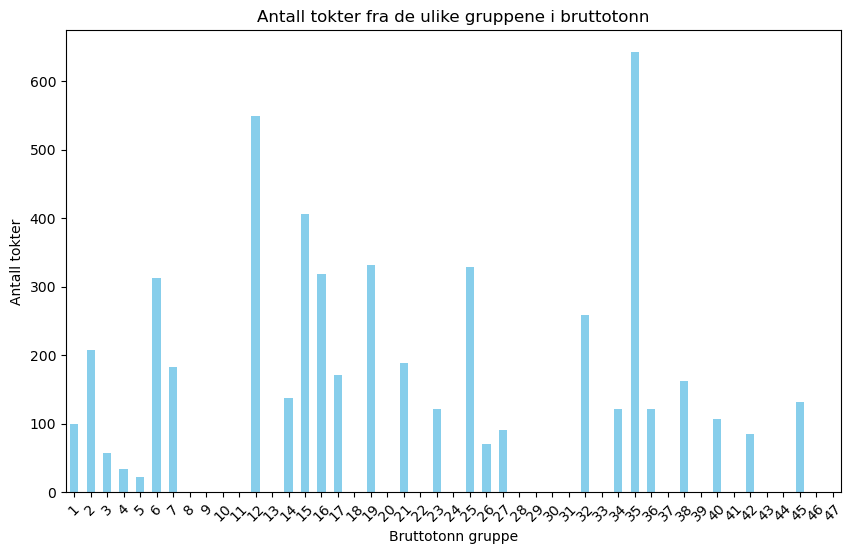

In [271]:
import matplotlib.pyplot as plt
# Gruppert etter størrelse på båten
bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()

# Genererer diagram
plt.figure(figsize=(10, 6))
bruttotonn_count.plot(kind='bar', color='skyblue')
plt.title('Antall tokter fra de ulike gruppene i bruttotonn')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Antall tokter')
plt.xticks(rotation=45)
plt.show()

In [272]:
# Group the data by 'Bruttotonnasje Gruppert' and calculate the sum of 'Rundvekt' for each group
rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/4084052864.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()


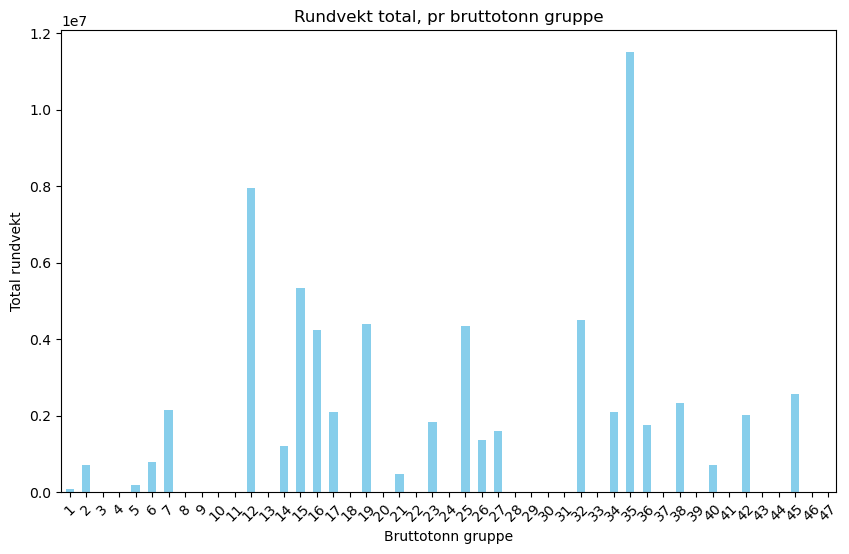

In [273]:
# Genererer diagram
plt.figure(figsize=(10, 6))
rundvekt_total_per_group.plot(kind='bar', color='skyblue')
plt.title('Rundvekt total, pr bruttotonn gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/1978392869.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()


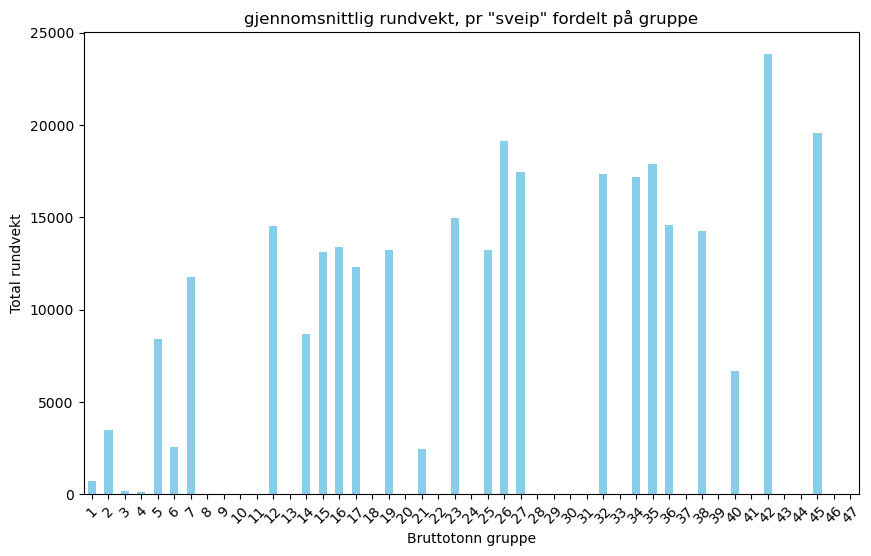

In [274]:
average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()

plt.figure(figsize=(10, 6))
average_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('gjennomsnittlig rundvekt, pr "sveip" fordelt på gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/815291654.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()


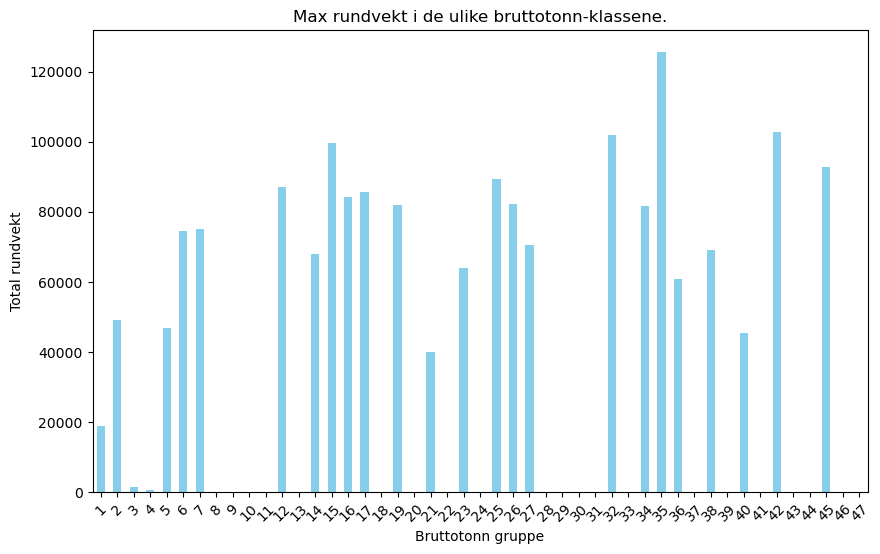

In [275]:
# Regne ut max kapasitet fra de ulike Bruttotonn-klassene.
max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()

plt.figure(figsize=(10, 6))
max_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('Max rundvekt i de ulike bruttotonn-klassene.')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

In [276]:
# Finne ut forventet rundvekt pr klasse. 

In [277]:
features = [
    'Bruttotonnasje Gruppert', 
    'Trekkavstand', 
    'Varighet', 
    'Havdybde start', 
    'Rundvekt', 
    'time_fraction'] # Binne varighet - Få timefraction i sinus.

df_cleaned = aggregated_df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Rundvekt'

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.2712939863535647


Resultater:
Rundvekt: 0.3073831319977236
Trekkavstand: 0.40293255889993773

In [278]:
print(len(y_train))
print(len(x_train))


4210
4210


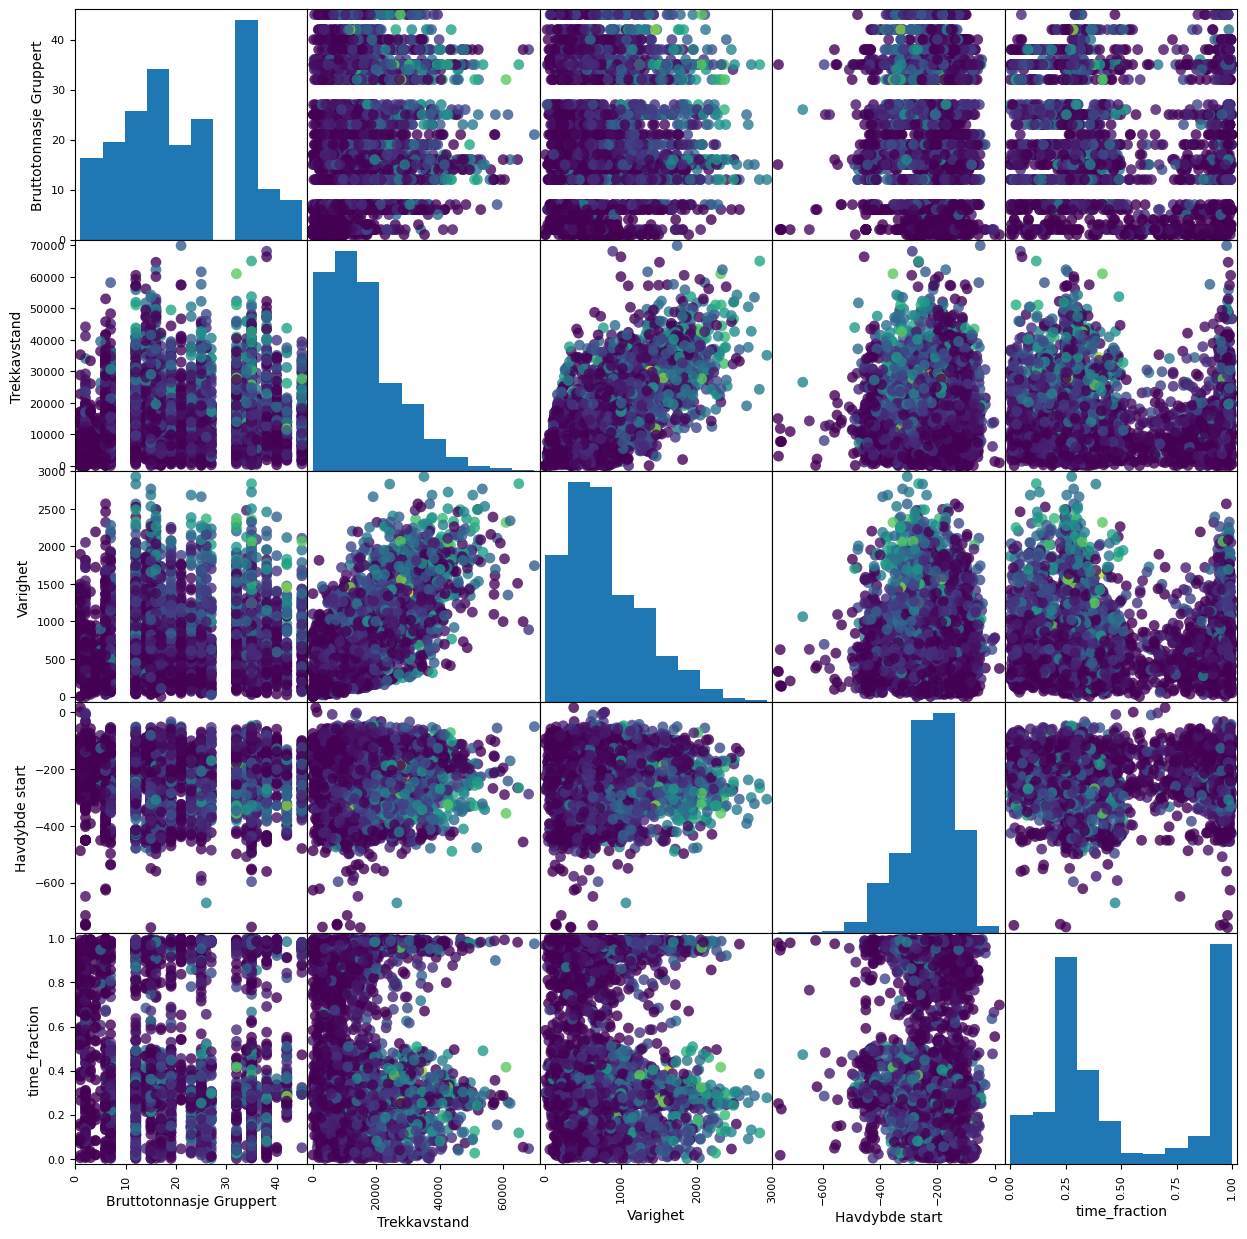

In [279]:
features.remove(predict)
# Assuming X and y_train are already defined
plot_frame = pd.DataFrame(x_train, columns=features)  # Use actual feature names

grr = pd.plotting.scatter_matrix(plot_frame, c=y_train, figsize=(15, 15), marker='o', s=60, alpha=.8)
plt.show()  # Ensure the plot displays in some environments

log_scaling? - 
trigonometric scaling.
    Brukt når ting varierer i bølger.
    (som tid) sin(time) lengden på bølgen er eit år.
    sin(tid) - lengden på bølgen er eit døgn.

Klassifisere kva som er "Godt" fiske:
    Deretter finne 


In [280]:
# Example of categorizing based on quantiles within each Bruttotonnasje Group
def categorize_fishing(row):
    if row['Rundvekt'] <= row['25th']:
        return 'Bad Fishing'
    elif row['Rundvekt'] <= row['50th']:
        return 'Average Fishing'
    elif row['Rundvekt'] <= row['75th']:
        return 'Good Fishing'
    else:
        return 'Excellent Fishing'

# Calculate quantiles within each group
quantiles = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].quantile([0.25, 0.5, 0.75]).unstack()
quantiles.columns = ['25th', '50th', '75th']

# Merge quantiles back with the original DataFrame
aggregated_df = aggregated_df.merge(quantiles, on='Bruttotonnasje Gruppert')

# Apply categorization
aggregated_df['Fishing Quality'] = aggregated_df.apply(categorize_fishing, axis=1)

aggregated_df


/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/3793052930.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].quantile([0.25, 0.5, 0.75]).unstack()


,Melding ID,Startposisjon bredde,Startposisjon lengde,Starttidspunkt,Havdybde start,Stopptidspunkt,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,...,Art - FDIR (kode),Art - gruppe (kode),Rundvekt,time_fraction,Lengdegruppe (kode),Bruttotonnasje Gruppert,25th,50th,75th,Fishing Quality
0,1497178,74.885,16.048,30.12.2017 23:21,-335,31.12.2017 21:47,1076,74.926,15.894,-358,...,"1027.0, 1022.0","202.0, 201.0",31884.0,0.000000,5.0,15,664.0,5899.0,20238.25,Excellent Fishing
1,1497423,74.838,15.966,01.01.2018 00:01,-329,01.01.2018 18:19,1936,74.832,16.206,-315,...,"1027.0, 1022.0","202.0, 201.0",19993.0,0.294444,5.0,15,664.0,5899.0,20238.25,Good Fishing
2,1497424,74.267,29.928,01.01.2018 09:57,-333,01.01.2018 20:34,917,74.288,30.196,-319,...,"1022.0, 1027.0","201.0, 202.0",37225.0,0.296528,5.0,15,664.0,5899.0,20238.25,Excellent Fishing
3,1497965,74.809,16.159,01.01.2018 19:22,-322,02.01.2018 21:04,2764,74.852,16.092,-358,...,"1027.0, 1022.0","202.0, 201.0",43019.0,0.285417,5.0,15,664.0,5899.0,20238.25,Excellent Fishing
4,1497968,74.219,30.012,02.01.2018 08:24,-329,02.01.2018 19:54,1276,74.204,29.961,-331,...,"1022.0, 1027.0","201.0, 202.0",32990.0,0.288194,5.0,15,664.0,5899.0,20238.25,Excellent Fishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5258,1790456,57.606,7.845,05.12.2018 21:21,-271,05.12.2018 22:21,60,57.615,7.892,-267,...,1022.0,201.0,35.0,0.934722,5.0,4,20.0,37.5,171.00,Average Fishing
5259,1791836,58.367,4.000,07.12.2018 13:30,-158,07.12.2018 23:07,1154,58.367,3.900,-146,...,"1022.0, 1027.0","201.0, 202.0",460.0,0.971528,5.0,4,20.0,37.5,171.00,Excellent Fishing
5260,1794685,57.881,6.310,12.12.2018 22:32,-283,13.12.2018 03:54,322,57.878,6.456,-288,...,1022.0,201.0,2.0,0.203472,5.0,4,20.0,37.5,171.00,Bad Fishing
5261,1796915,57.539,7.433,17.12.2018 02:14,-230,17.12.2018 20:30,2192,57.513,7.541,-211,...,"1022.0, 1027.0","201.0, 202.0",44.0,0.856944,5.0,4,20.0,37.5,171.00,Good Fishing


Finne: 
    - gjennomsnittsfangst - Sortere god fangst fra dårlig.
    - God fangst:
        - gjennomsnittsfangst basert på: 


Luke ut ekstremfangster - Dårlige og gode fangster.
        

Finne 
kjøre lineær analyse av fangst.
        Normalisering:
        https://developers.google.com/machine-learning/data-prep/transform/normalization

predikere god fangst basert på bruttotonn gruppe.
    


In [281]:
# Let's assume 'df' is your DataFrame and 'Bruttotonnasje Gruppert' is already defined

# Step 1: Calculate the average 'Rundvekt' for each 'Bruttotonnasje Gruppert' that has data
average_rundvekt_per_group = df_cleaned.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()

# Step 2: Identify the missing classes and decide on a strategy to fill them in
# For simplicity, let's interpolate the missing values
average_rundvekt_per_group = average_rundvekt_per_group.interpolate()

# If interpolation is not suitable, you could use a different method, such as:
# average_rundvekt_per_group.fillna(global_average_rundvekt, inplace=True)

# Step 3: Create a mapping from 'Bruttotonnasje Gruppert' to the expected average 'Rundvekt'
expected_average_rundvekt = average_rundvekt_per_group.to_dict()

# Apply the expected averages to your original DataFrame (if needed)
df_cleaned['Expected Average Rundvekt'] = df_cleaned['Bruttotonnasje Gruppert'].map(expected_average_rundvekt)

# Now, df has a new column 'Expected Average Rundvekt' with the expected averages based on boat size

df_cleaned

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_28757/469449176.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rundvekt_per_group = df_cleaned.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()


,Melding ID,Startposisjon bredde,Startposisjon lengde,Starttidspunkt,Havdybde start,Stopptidspunkt,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,time_fraction,Lengdegruppe (kode),Bruttotonnasje Gruppert,Expected Average Rundvekt
0,1497178,74.885,16.048,30.12.2017 23:21,-335,31.12.2017 21:47,1076,74.926,15.894,-358,14368.0,51.0,"1027.0, 1022.0","1027.0, 1022.0","202.0, 201.0",31884.0,0.000000,5.0,15,13129.847291
1,1497311,73.127,28.324,01.01.2018 17:09,-302,01.01.2018 18:36,174,73.187,28.390,-258,14056.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",4052.0,0.933333,5.0,19,13254.199396
2,1497330,74.307,30.293,01.01.2018 01:16,-317,01.01.2018 21:58,761,74.190,30.274,-319,24736.0,51.0,1022.0,1022.0,201.0,65800.0,0.965972,5.0,45,19567.557252
3,1497342,71.262,25.188,01.01.2018 07:58,-289,01.01.2018 20:32,1446,71.292,24.904,-294,31982.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",9237.0,0.979167,5.0,7,11742.311475
4,1497352,71.227,24.085,01.01.2018 01:16,-317,01.01.2018 12:54,1224,71.255,24.171,-303,30380.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",13564.0,0.987500,5.0,12,14500.544627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5258,1800152,76.492,14.435,30.12.2018 03:35,-232,30.12.2018 09:55,760,76.502,14.221,-280,11382.0,51.0,1027.0,"1027.0, 1022.0","202.0, 201.0",13896.0,0.297917,5.0,15,13129.847291
5259,1800158,62.650,4.122,30.12.2018 10:48,-187,30.12.2018 15:30,282,62.656,4.082,-191,2157.0,51.0,1032.0,1022.0,201.0,60.0,0.334722,5.0,21,2468.285714
5260,1800189,74.874,16.415,31.12.2018 03:14,-261,31.12.2018 09:17,726,74.864,16.165,-343,14744.0,51.0,1027.0,"1027.0, 1022.0","202.0, 201.0",9428.0,0.540972,5.0,12,14500.544627
5261,1800230,71.409,27.405,30.12.2018 21:26,-349,31.12.2018 10:37,1454,71.316,27.609,-343,34012.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",12145.0,0.874306,5.0,12,14500.544627


In [282]:
# Calculate the average 'Rundvekt' for each 'Bruttotonnasje Gruppe'
df_cleaned.boxplot
# innebygde funksjoner    - Box plot - Sjekk
def categorize_rundvekt(rundvekt, average_rundvekt):
    if rundvekt < 0.5 * average_rundvekt:
        return 'below 50% of average'
    elif 0.5 * average_rundvekt <= rundvekt < average_rundvekt:
        return 'between 50 and 100% of average'
    elif 1.5 * average_rundvekt <= rundvekt < 2 * average_rundvekt:
        return 'between 150% and 200% of average'
    elif rundvekt >= 2 * average_rundvekt:
        return 'over 200% of average'
    else:
        return 'average'


# Use the 'apply' method with a lambda function to categorize each row
df_cleaned['Rundvekt Category'] = df_cleaned.apply(lambda row: categorize_rundvekt(row['Rundvekt'], row('Expected Average Rundvekt')), axis=1)




TypeError: 'Series' object is not callable